In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

warnings.filterwarnings('ignore', category=UserWarning)

df = pd.read_csv('BTCUSD.csv', parse_dates=['time'],
                 date_parser=lambda x: pd.to_datetime(x, unit='ms'),
                 index_col='time')

In [2]:
# Moving average calculation through Pandas window functionality
# windows_count: size of window to rolling by 
windows_count = 80
df['close_ewm'] = df['close'].ewm(span=windows_count).mean()

In [3]:
import numpy.ma as mask_arrays
from matplotlib.dates import date2num

example_size = 500
sample = df[windows_count:windows_count+example_size]
index = date2num(sample.index.to_pydatetime())

upper_ewm = mask_arrays.masked_where(
    sample['close_ewm'] < sample['close'], sample['close_ewm'])
lower_ewm = mask_arrays.masked_where(
    sample['close_ewm'] > sample['close'], sample['close_ewm'])

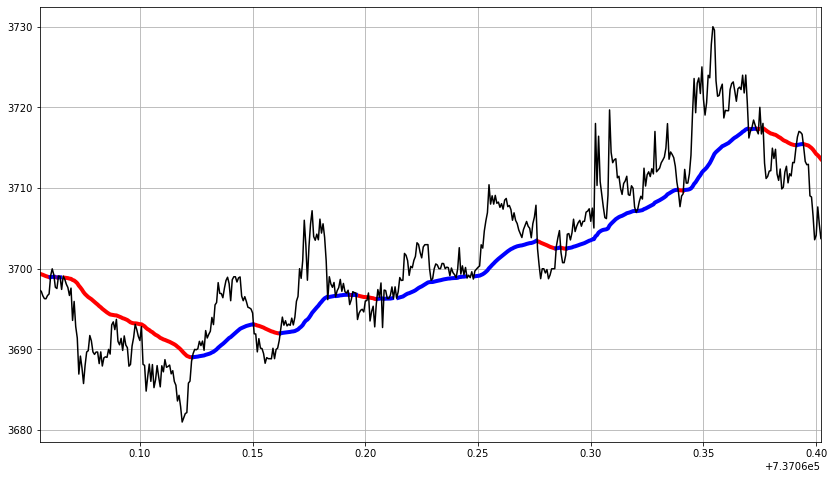

In [4]:
_, ax = plt.subplots(figsize=(14, 8))
ax.plot(index, upper_ewm, 'red',
        index, lower_ewm, 'blue', linewidth=4)
ax.plot(index, sample['close'], 'black')
plt.xlim(index.min(), index.max())
ax.grid(True)

### Below:
Class definition for test mean reversion strategy

In [5]:
#from numba import jit

class MeanReversionStrategy:
    def __init__(self, windows_count_, percent_, frame_):
        self.windows = windows_count_
        self.percent = percent_
        self.df = frame_
        
    def __compute_ewm(self):
        ewm = self.df['close'].ewm(span=self.windows).mean()
        self.df['close_ewm'] = ewm
    
    def __compute_ewm_bounds(self):
        upper = (1 + self.percent) * self.df['close_ewm']
        lower = (1 - self.percent) * self.df['close_ewm']
        return upper, lower
        
    def __short_pnl(self, open_price, close_price, amount=1):
        return (open_price - close_price) * amount
    
    def __long_pnl(self, open_price, close_price, amount=1):
        return (close_price - open_price) * amount    
    
    #@jit(nopython=True)
    def __get_pnl(self) -> tuple:
        upper, lower = self.__compute_ewm_bounds()
        ewm = self.df['close_ewm']
        open_price = None
        direction = None
        is_open = False
        pnl_list = []
        directions = []
        open_date = None
        pnl_dates = []
        
        # For Numba
        #close_ = self.df['close'].values
        #upper, lower = upper.values, lower.values
        
        for i in self.df.index:
            if not is_open:
                if self.df.loc[i, 'close'] > upper.loc[i]:
                    is_open = True
                    open_price = self.df.loc[i, 'close']
                    direction = 'short'
                    open_date = i
                elif self.df.loc[i, 'close'] < lower.loc[i]:
                    is_open = True
                    open_price = self.df.loc[i, 'close']
                    direction = 'long'
                    open_date = i

            directions.append(direction)
            
            if is_open:
                if self.df.loc[i, 'close'] <= ewm.loc[i] and direction == 'short':
                    is_open = False
                    direction = None
                    close_price = self.df.loc[i, 'close']
                    pnl_list.append(self.__short_pnl(open_price, close_price))
                    close_date = i
                    pnl_dates.append((open_date, close_date))
                elif self.df.loc[i, 'close'] >= ewm.loc[i] and direction == 'long':
                    is_open = False
                    direction = None
                    close_price = self.df.loc[i, 'close']
                    pnl_list.append(self.__long_pnl(open_price, close_price))
                    close_date = i
                    pnl_dates.append((open_date, close_date))
        
        return pnl_list, directions, pnl_dates
    
    def __get_weights(self, directions):
        dir_to_weigth = {'short': -1, 'long': 1, None: 0}
        weigths = list(map(lambda x: dir_to_weigth[x], directions))
        return weigths
    
    def __count_pnl_periods(self, pnl_list):
        profits = [x for x in pnl_list if x > 0]
        losses = [x for x in pnl_list if x < 0]
        return len(profits), len(losses)
    
    def __get_daily_pnl(self, pnl_list):
        start_day = self.df.index[0]
        end_day = self.df.index[-1]
        days_count = (end_day - start_day).days
        return sum(pnl_list) / days_count
    
    def execute(self) -> tuple:
        self.__compute_ewm()
        pnls, dirs, dates = self.__get_pnl()
        pos_neg_periods = self.__count_pnl_periods(pnls)
        daily = self.__get_daily_pnl(pnls)
        pnl_cumsum = np.cumsum(pnls)
        w = self.__get_weights(dirs)
        return pnl_cumsum, w, pos_neg_periods, daily

In [6]:
import time

percent = 0.01
strategy = MeanReversionStrategy(windows_count, percent, df)
start = time.time()
pnls, weights, (pos, neg), daily_ = strategy.execute()
end = time.time()
print('Execution time: {:.4f}'.format(end - start))

Execution time: 65.3525


In [7]:
print(f'Count of negative periods: {neg}')
print(f'Count of positive periods: {pos}')
print(f'Daily PnL: {daily_}')

Count of negative periods: 293
Count of positive periods: 521
Daily PnL: -10.95587912087917


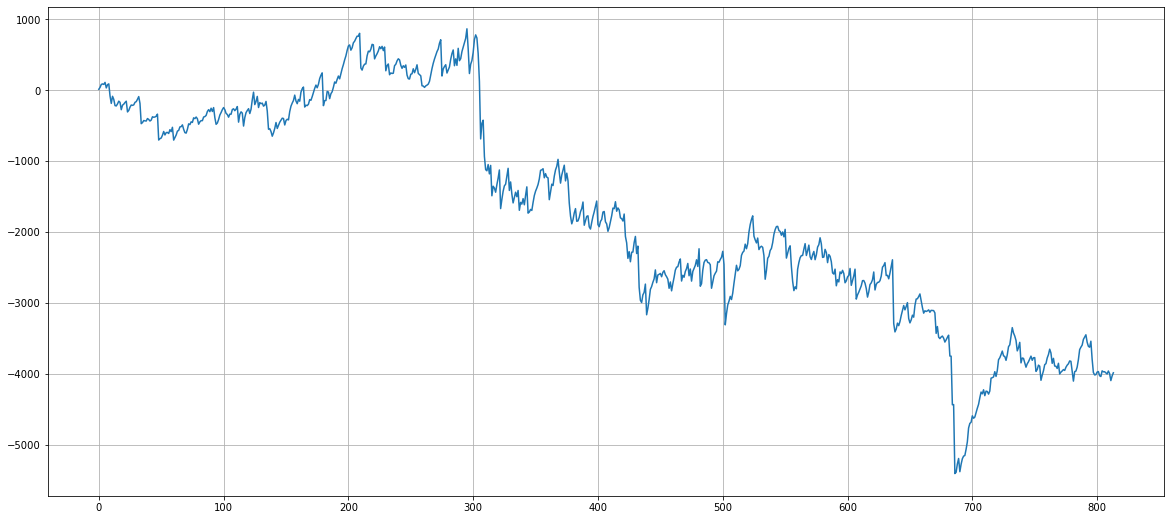

In [8]:
plt.figure(figsize=(20, 9))
plt.plot(pnls)
plt.grid(True)

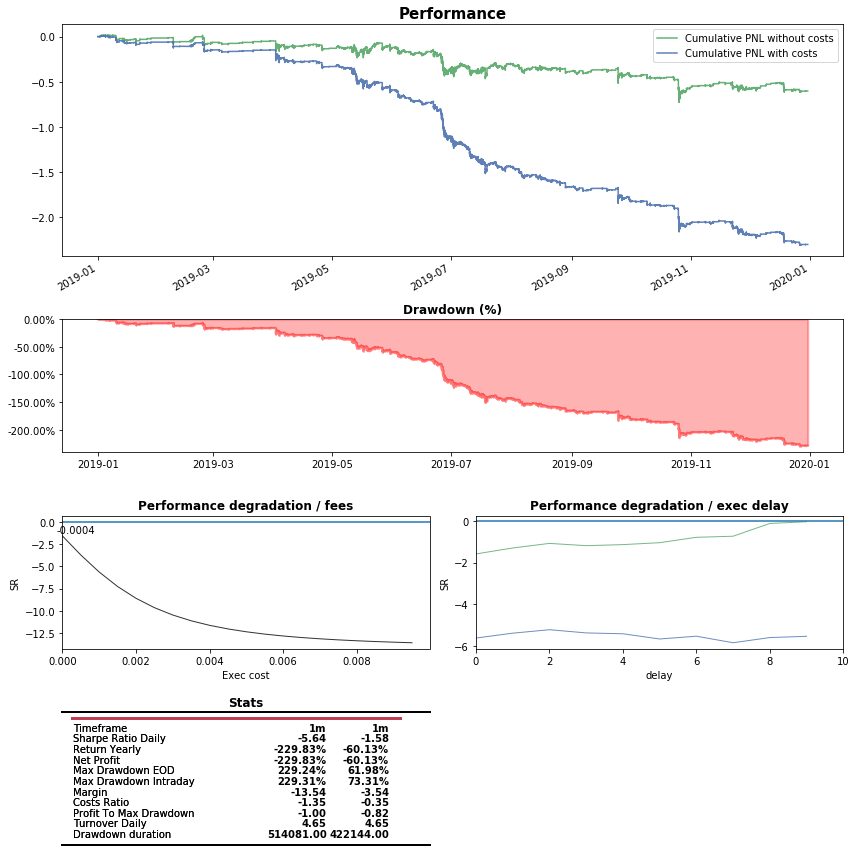

In [9]:
from vecbacktest.executor import ExecutorWeights
from reports.report import StatsCalculator
from reports.report_plots import Plotter

close = pd.DataFrame(df['close'], index=df.index)
fee_ = 0.001
fundings_ = None
spread_ = 0
tick_spread_ = None
delay_ = 1
inverse_ = False

ew = ExecutorWeights(fee=fee_, closes=close, fundings=fundings_,
                     const_spread=spread_, const_tick_spread=tick_spread_,
                     inverse_pnl=inverse_, delay=delay_)

weights = pd.DataFrame(weights, index=df.index, columns=['close'])
res = ew.backtest_strategy(weights)
pnl = res['pnl'].sum(axis=1, skipna=True)
costs = res['costs'].sum(axis=1,skipna=True)
turnover = res['turnover'].sum(axis=1, skipna=True)
delay_stats = res['delay_stat']
stats = StatsCalculator.collect(pnl=pnl, costs=costs, turnover=turnover)    
Plotter.basic_plot(pnl=pnl, costs=costs, turnover=turnover,
                   delay_stats=delay_stats, stats=stats, plot_no_costs=True)

In [10]:
pnl_periods = res['count_pnl_periods']
daily_pnl = res['daily_pnl']

print('Count of pnl periods\n'
      f'profits: {pnl_periods[0]}\n'
      f'losses: {pnl_periods[1]}')

print(f'Daily pnl: {daily_pnl}')

Count of pnl periods
profits: 454
losses: 461
Daily pnl: -0.0016519069361070572
